<a href="https://colab.research.google.com/github/kusha31393/Finetune_qwen2.5_VL/blob/main/finetune_qwen_vl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 26.5 MB/s eta 0:00:00


In [ ]:
from unsloth import FastVisionModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.9.4: Fast Qwen2_Vl patching. Transformers: 4.56.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.90G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state = 3407,
    use_rslora=False,
    loftq_config=None
)

Unsloth: Making `model.base_model.model.model.visual` require gradients


In [ ]:
from datasets import load_dataset
dataset = load_dataset("unsloth/Latex_OCR", split="train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [ ]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>,
 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}

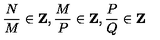

In [ ]:
dataset[0]['image']

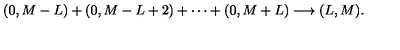

In [ ]:
dataset[42837]['image']

In [ ]:
dataset[42837]['text']

'( 0 , M - L ) + ( 0 , M - L + 2 ) + \\cdots + ( 0 , M + L ) \\longrightarrow ( L , M ) .'

In [ ]:
instruction = "Write the LaTex representation for this image."

In [ ]:
def convert_to_conversation(sample):
  conversation = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": instruction},
              {"type": "image", "image": sample["image"]}
          ]
      },
      {
          "role": "assistant",
          "content": [
              {"type": "text", "text": sample["text"]}
          ]
      }

  ]
  return {"messages": conversation}

In [ ]:
convert_to_conversation(dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [ ]:
converted_dataset[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,'}]}]}

In [ ]:
FastVisionModel.for_inference(model)

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=False)


In [ ]:
image = dataset[1]["image"]
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": image}
        ]
    }
]

In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1)

$$D _ { \mu } ^ { A } A _ { \mu } ^ { B } = 0 ,$$<|im_end|>


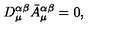

In [ ]:
image

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [ ]:
FastVisionModel.for_inference(model)

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=False)


In [ ]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    )
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.205800
2,1.332300
3,1.406200
4,1.017100
5,1.062100
6,1.093900
7,0.911500
8,0.592800
9,0.514000
10,0.499000


TrainOutput(global_step=30, training_loss=0.4421761261920134, metrics={'train_runtime': 336.0605, 'train_samples_per_second': 0.714, 'train_steps_per_second': 0.089, 'total_flos': 1673161698422784.0, 'train_loss': 0.4421761261920134, 'epoch': 0.0034941618379291267})

In [ ]:
FastVisionModel.for_inference(model)

PeftModel(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=False)


In [ ]:
image = dataset[2]["image"]

In [ ]:
instruction = "Write the LateX representation for this image."

In [ ]:
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \xi ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \xi ^ { \dagger } \zeta \right\} \ .<|im_end|>


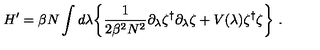

In [ ]:
image